# Monotonic Neural Network - Joseph Sill 1997

## 0. Library imports

In [1]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# model
from models.minmax import MonotonicNet

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
# make this work

# # Set random seed
# torch.manual_seed(42)
# np.random.seed(42)

# # Set device
# if (int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13) and torch.has_mps:
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# # Set matplotlib style
# matplotlib.rcParams["figure.dpi"] = 200
# matplotlib.rcParams["font.size"] = 8

## 1. Function Examples

### 2.1 $f(x) = (x+1)^2$: monotonic increasing in $x$

In [3]:
# define space
X_tensor_f1 = torch.linspace(-1, 1, 1000)
Z1_tensor = torch.tensor(f1(X_tensor_f1))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_36090/1116920515.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z1_tensor = torch.tensor(f1(X_tensor_f1))


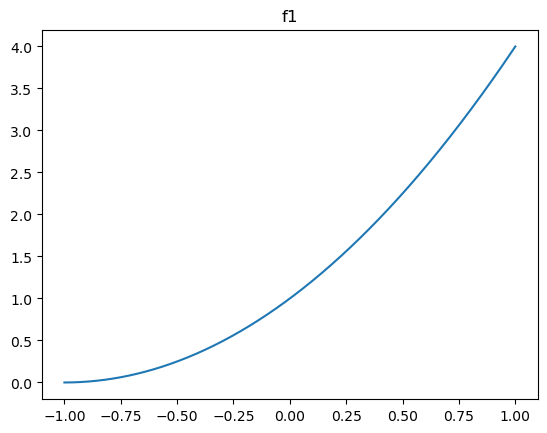

In [4]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1.cpu().detach(), Z1_tensor.cpu().detach(), label='f1')
plt.title('f1')
plt.savefig('figures/f1.png')
plt.show()

In [6]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [10] # number of neurons in each group
number_groups = [10] # number of groups
increasing = [True] # increasing or decreasing
monotonic = [True]
# initial learning rate
LR = 1e-3

# defining the model
model_f1 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f1 = nn.MSELoss()
optimizer_f1 = torch.optim.Adam(model_f1.parameters(), lr=LR)
scheduler_f1 = torch.optim.lr_scheduler.StepLR(optimizer_f1, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f1.shape[0]

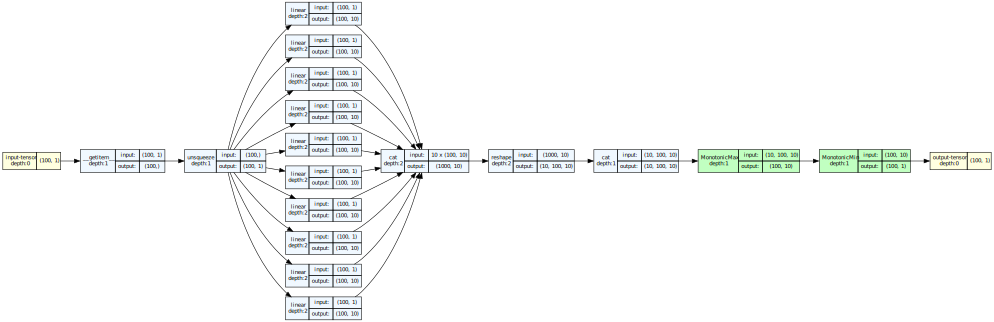

In [7]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f1, input_size=(100, n_features_in), graph_name=model_f1.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [8]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f1 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f1.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f1[idx], Z1_tensor[idx]

        # zero grad
        optimizer_f1.zero_grad()

        # forward pass
        output = model_f1(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f1(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f1.step()

    # update LR
    scheduler_f1.step()

    losses_f1.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f1[-1]:.7f} - LR {optimizer_f1.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:56<00:00,  8.88it/s, Loss 0.0000410 - LR 0.0002373]


In [9]:
# prediction
with torch.no_grad():
    model_f1.eval()
    y_pred = model_f1(X_tensor_f1.unsqueeze(1))

final_loss = criterion_f1(y_pred, Z1_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f1[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 4.095832799066557e-05
Epoch 500 - test loss: 3.9114984247135e-05


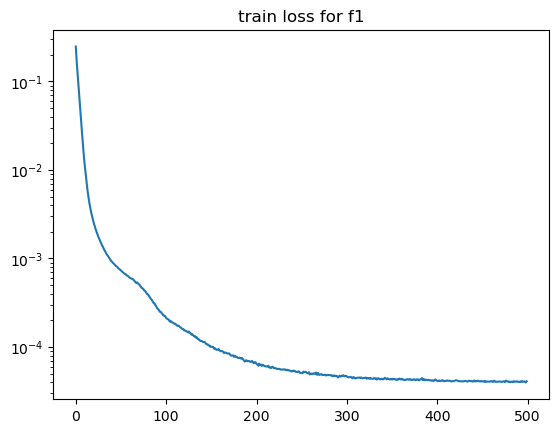

In [10]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f1, label='train loss')
plt.yscale('log')
plt.title('train loss for f1')
plt.savefig('figures/train_loss_f1.png')
plt.show()

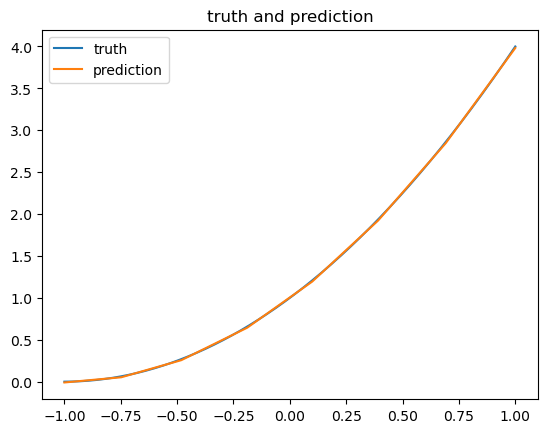

In [11]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1, Z1_tensor, label='truth')
plt.plot(X_tensor_f1, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/truth_prediction_f1.png')
plt.show()

### 2.2 $f(x) = -(x+1)^2$: monotonic decreasing in $x$

In [12]:
# define space
X_tensor_f2 = torch.linspace(-1, 1, 1000)
Z2_tensor = torch.tensor(f2(X_tensor_f2))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_36090/2149639300.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z2_tensor = torch.tensor(f2(X_tensor_f2))


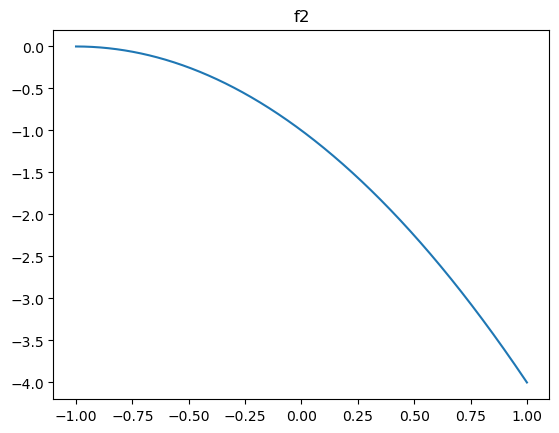

In [13]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2.cpu().detach(), Z2_tensor.cpu().detach(), label='f2')
plt.title('f2')
plt.savefig('figures/f2.png')
plt.show()

In [14]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [10] # number of neurons in each group
number_groups = [10] # number of groups
increasing = [False] # increasing or decreasing
monotonic = [True]
# initial learning rate
LR = 1e-3

# defining the model
model_f2 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f2 = nn.MSELoss()
optimizer_f2 = torch.optim.Adam(model_f2.parameters(), lr=LR)
scheduler_f2 = torch.optim.lr_scheduler.StepLR(optimizer_f2, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f2.shape[0]

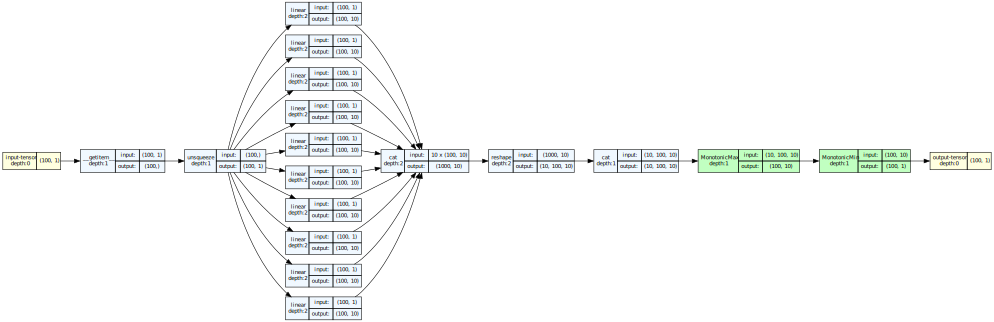

In [15]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f2, input_size=(100, n_features_in), graph_name=model_f2.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [16]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f2 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f2.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f2[idx], Z2_tensor[idx]

        # zero grad
        optimizer_f2.zero_grad()

        # forward pass
        output = model_f2(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f2(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f2.step()

    # update LR
    scheduler_f2.step()

    losses_f2.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f2[-1]:.7f} - LR {optimizer_f2.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:58<00:00,  8.60it/s, Loss 0.0056086 - LR 0.0002373]


In [17]:
# prediction
with torch.no_grad():
    model_f2.eval()
    y_pred = model_f2(X_tensor_f2.unsqueeze(1))

final_loss = criterion_f2(y_pred, Z2_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f2[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 0.005608598773833364
Epoch 500 - test loss: 0.0055783470161259174


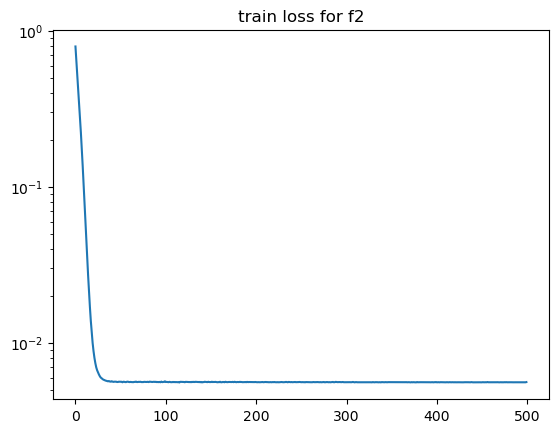

In [18]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f2, label='train loss')
plt.yscale('log')
plt.title('train loss for f2')
plt.savefig('figures/train_loss_f2.png')
plt.show()

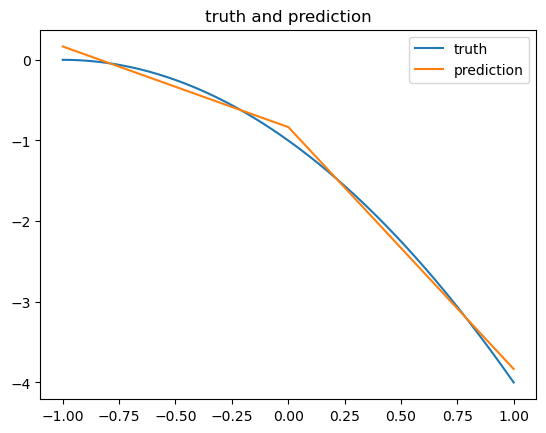

In [19]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2, Z2_tensor, label='truth')
plt.plot(X_tensor_f2, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/truth_prediction_f2.png')
plt.show()

### 2.3 $f(x, y) = x+y$: monotonic increasing in $x$ and $y$

In [20]:
# define space
X_tensor_f3 = torch.linspace(-1, 1, 100)
Y_tensor_f3 = torch.linspace(-1, 1, 100)
X_tensor_f3_2D, Y_tensor_f3_2D = torch.meshgrid(X_tensor_f3, Y_tensor_f3)
Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_36090/1277584719.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_36090/2477673157.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()


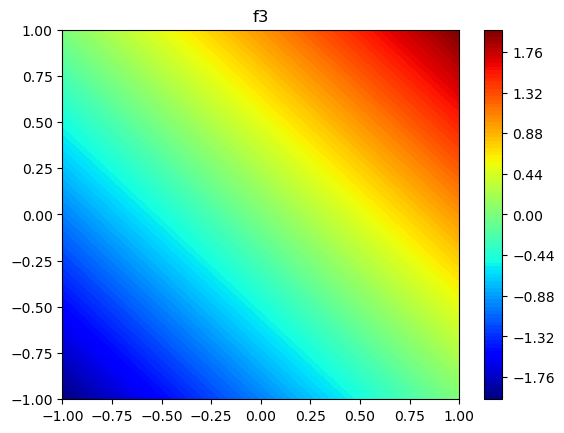

In [21]:
X_tensor_2d = torch.cat((X_tensor_f3_2D.unsqueeze(2), Y_tensor_f3_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f3')
plt.savefig('figures/f3.png')
plt.show()

In [22]:
# NN parameters
n_features_in = 2
group_size = [10, 10]
number_groups = [5, 5] 
increasing = [True, True]
monotonic = [True, True]
# initial learning rate
LR = 1e-4

# defining the model
model_f3 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f3 = nn.MSELoss()
optimizer_f3 = torch.optim.Adam(model_f3.parameters(), lr=LR)
scheduler_f3 = torch.optim.lr_scheduler.StepLR(optimizer_f3, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

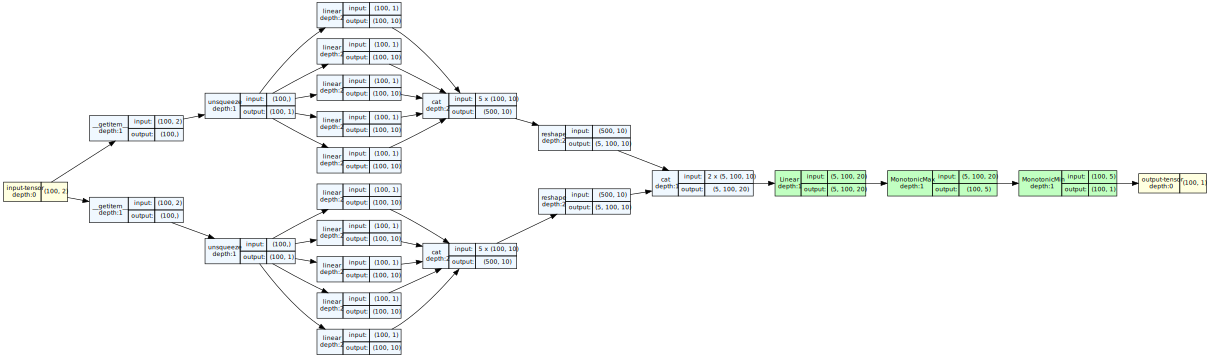

In [23]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f3, input_size=(100, n_features_in), graph_name=model_f3.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [24]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f3 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f3.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z3_tensor[idx]

        # zero grad
        optimizer_f3.zero_grad()

        # forward pass
        output = model_f3(batch_x)

        # compute loss
        loss = criterion_f3(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f3.step()

    # update LR
    scheduler_f3.step()

    losses_f3.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f3[-1]:.7f} - LR {optimizer_f3.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:29<00:00, 16.79it/s, Loss 0.0000000 - LR 0.0000237]


In [25]:
# prediction
with torch.no_grad():
    model_f3.eval()
    y_pred = model_f3(X_tensor_2d)

final_loss = criterion_f3(y_pred, Z3_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f3[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 4.688205119257605e-13
Epoch 500 - test loss: 4.925725964805873e-14


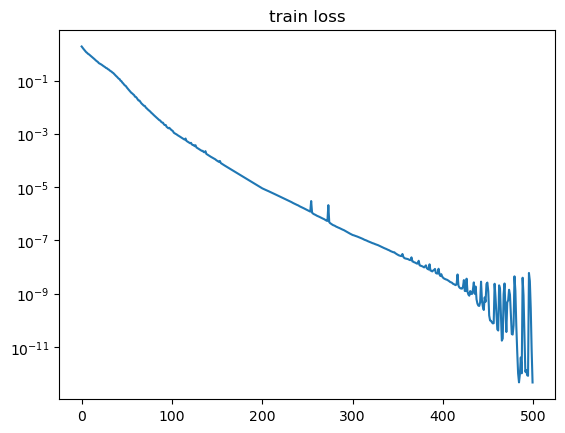

In [26]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f3, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/train_loss_f3.png')
plt.show()

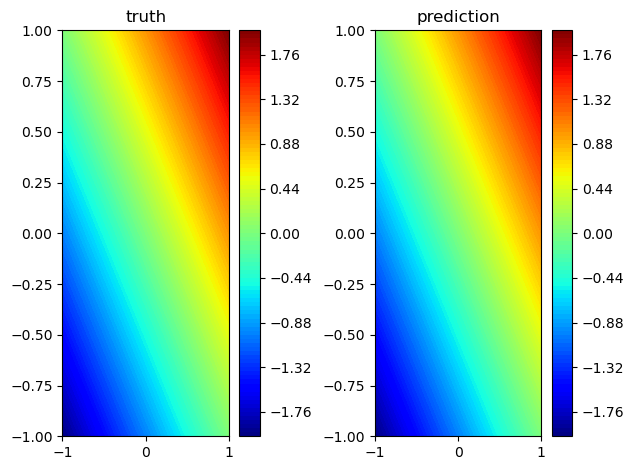

In [27]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/truth_prediction_f3.png')
plt.show()

### 2.4 $f(x, y) = x-y$: monotonic increasing in $x$, decreasing in $y$ 

In [112]:
# define space
X_tensor_f4 = torch.linspace(-1, 1, 100)
Y_tensor_f4 = torch.linspace(-1, 1, 100)
X_tensor_f4_2D, Y_tensor_f4_2D = torch.meshgrid(X_tensor_f4, Y_tensor_f4)
Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65908/3655634531.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65908/3922313273.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()


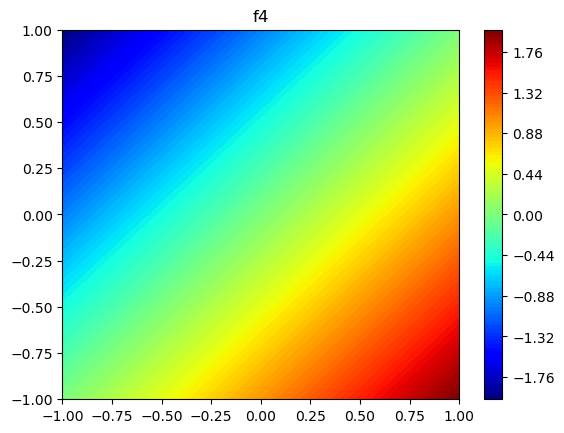

In [113]:
X_tensor_2d = torch.cat((X_tensor_f4_2D.unsqueeze(2), Y_tensor_f4_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f4')
plt.savefig('figures/f4.png')
plt.show()

In [117]:
# NN parameters
n_features_in = 2
group_size = [10, 10]
number_groups = [5, 5] 
increasing = [True, False]
monotonic = [True, True]
# initial learning rate
LR = 1e-4

# defining the model
model_f4 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f4 = nn.MSELoss()
optimizer_f4 = torch.optim.Adam(model_f4.parameters(), lr=LR)
scheduler_f4 = torch.optim.lr_scheduler.StepLR(optimizer_f4, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

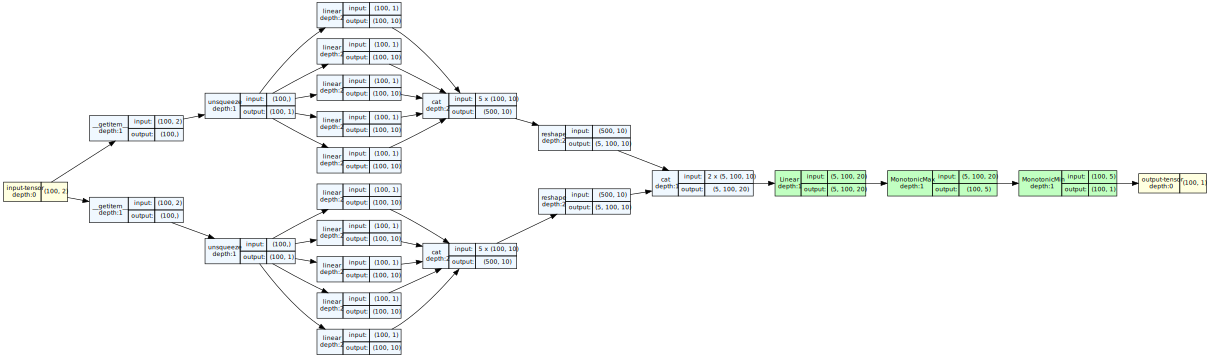

In [118]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f4, input_size=(100, n_features_in), graph_name=model_f4.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [119]:
# training loop
EPOCHS = 300
BATCH_SIZE = 256

losses_f4 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f4.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z4_tensor[idx]

        # zero grad
        optimizer_f4.zero_grad()

        # forward pass
        output = model_f4(batch_x)

        # compute loss
        loss = criterion_f4(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f4.step()

    # update LR
    scheduler_f4.step()

    losses_f4.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f4[-1]:.7f} - LR {optimizer_f4.param_groups[0]['lr']:.7f}")
    

Epoch 299: 100%|██████████| 300/300 [00:28<00:00, 10.68it/s, Loss 0.0000001 - LR 0.0000422]


In [120]:
# prediction
with torch.no_grad():
    model_f4.eval()
    y_pred = model_f4(X_tensor_2d)

final_loss = criterion_f4(y_pred, Z4_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f4[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 300 - train loss: 1.465990138650405e-07
Epoch 300 - test loss: 1.439017296434031e-07


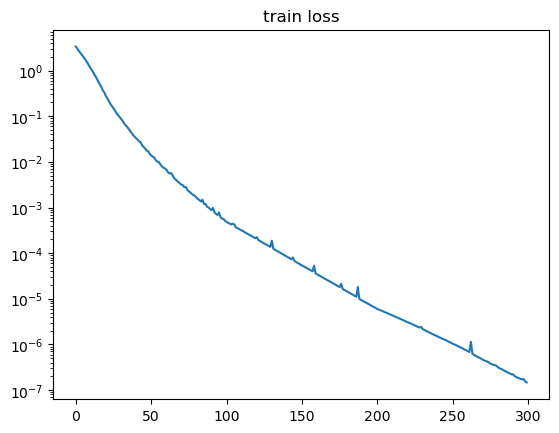

In [121]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f4, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/train_loss_f4.png')
plt.show()

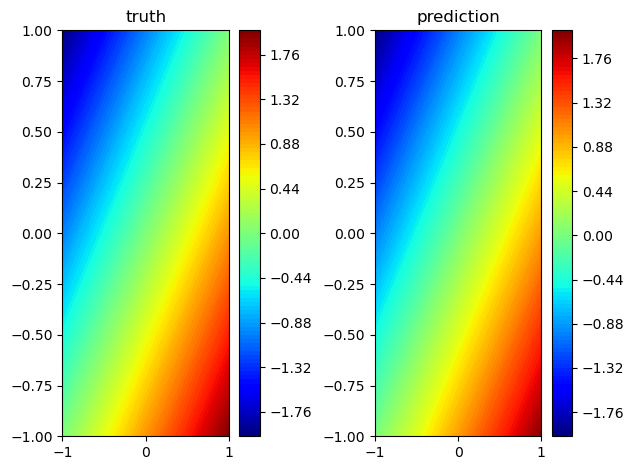

In [122]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/truth_prediction_f4.png')

plt.show()

### 2.5 $f(x) = cos(x)$: non-monotonic 

In [123]:
# define space
X_tensor_f5 = torch.linspace(-1, 1, 1000)
Z5_tensor = torch.tensor(f5(X_tensor_f5))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65908/3014222509.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z5_tensor = torch.tensor(f5(X_tensor_f5))


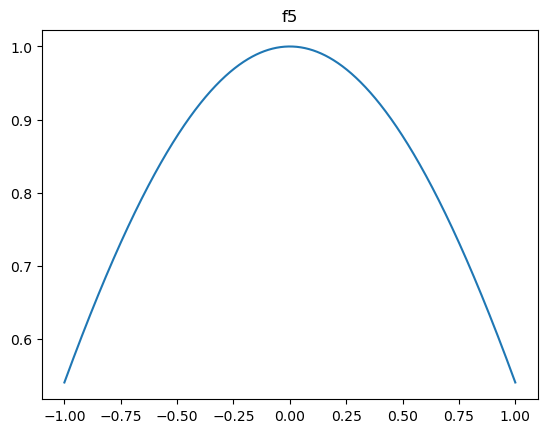

In [124]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5.cpu().detach(), Z5_tensor.cpu().detach(), label='f5')
plt.title('f5')
plt.savefig('figures/f5.png')
plt.show()

In [137]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [5] # number of neurons in each group
number_groups = [5] # number of groups
increasing = [True] # increasing or decreasing
monotonic = [False]
# initial learning rate
LR = 1e-3

# defining the model
model_f5 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f5 = nn.MSELoss()
optimizer_f5 = torch.optim.Adam(model_f5.parameters(), lr=LR)
scheduler_f5 = torch.optim.lr_scheduler.StepLR(optimizer_f5, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f5.shape[0]

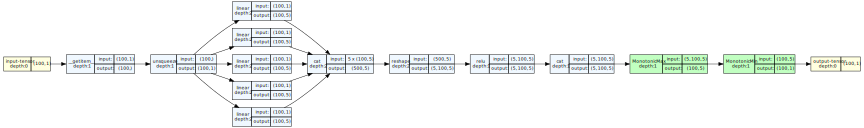

In [138]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f5, input_size=(100, n_features_in), graph_name=model_f5.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [139]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f5 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f5.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f5[idx], Z5_tensor[idx]

        # zero grad
        optimizer_f5.zero_grad()

        # forward pass
        output = model_f5(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f5(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f5.step()

    # update LR
    scheduler_f5.step()

    losses_f5.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f5[-1]:.7f} - LR {optimizer_f5.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:50<00:00,  9.84it/s, Loss 0.0000260 - LR 0.0002373]


In [140]:
# prediction
with torch.no_grad():
    model_f5.eval()
    y_pred = model_f5(X_tensor_f5.unsqueeze(1))

final_loss = criterion_f5(y_pred, Z5_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f5[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 2.6012201315097626e-05
Epoch 500 - test loss: 2.6929275918519124e-05


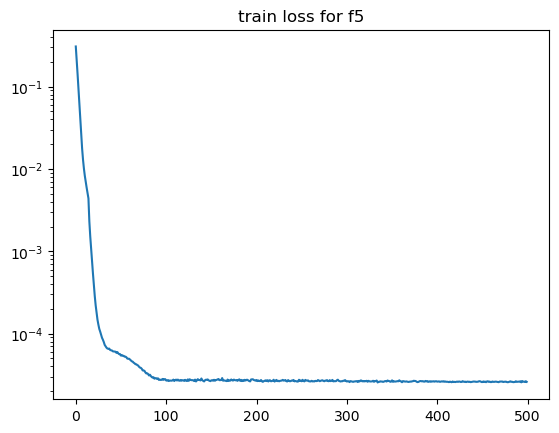

In [141]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f5, label='train loss')
plt.yscale('log')
plt.title('train loss for f5')
plt.savefig('figures/train_loss_f5.png')
plt.show()

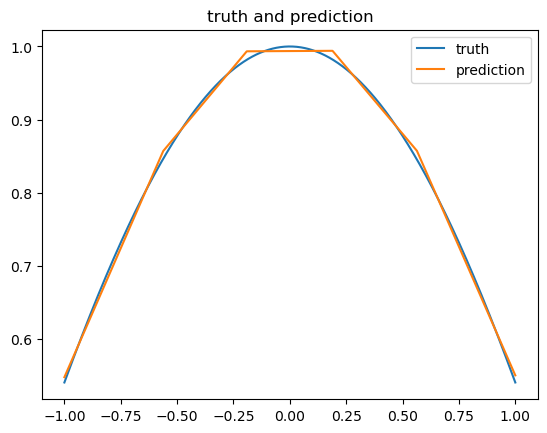

In [142]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5, Z5_tensor, label='truth')
plt.plot(X_tensor_f5, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/truth_prediction_f5.png')
plt.show()

### 2.6 $f(x, y) = x^3 + 0.5*sin(4*\pi*y)$: monotonic increasing in $x$ and non-monotonic in $y$

In [143]:
# define space
X_tensor_f6 = torch.linspace(-1, 1, 100)
Y_tensor_f6 = torch.linspace(-1, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65908/1141456262.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65908/2114009038.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()


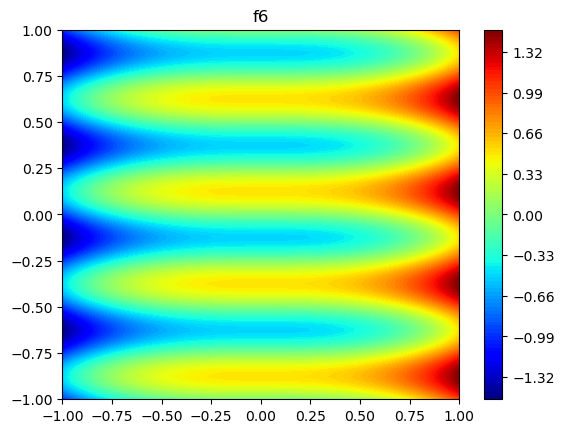

In [144]:
X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=1).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
plt.savefig('figures/f6.png')
plt.show()

In [166]:
# NN parameters
n_features_in = 2 
group_size = [5, 5]
number_groups = [5, 5]
increasing = [True, True]
monotonic = [True, False]

# initial learning rate
LR = 1e-4

# defining the model
model_f6 = MonotonicNet(input_size=n_features_in, num_groups=number_groups, group_sizes=group_size, increasing=increasing, monotonic=monotonic)

# defining the loss function, the optimizer and the scheduler
criterion_f6 = nn.MSELoss()
optimizer_f6 = torch.optim.Adam(model_f6.parameters(), lr=LR)
# scheduler_f6 = torch.optim.lr_scheduler.StepLR(optimizer_f6, step_size=100, gamma=0.75)
# cosine scheduler
scheduler_f6 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f6, T_max=100, eta_min=1e-6)
n_samples_train = X_tensor_2d.shape[0]

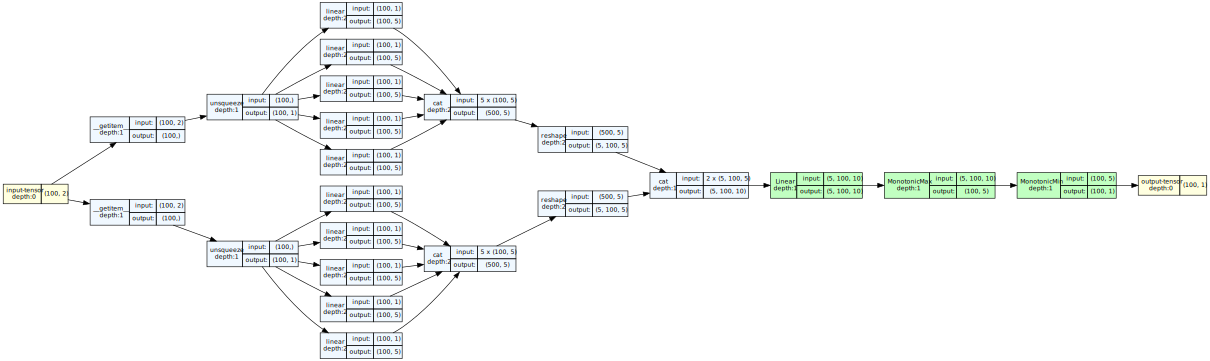

In [167]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f6, input_size=(100, n_features_in), graph_name=model_f6.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [168]:
# training loop
EPOCHS = 500
BATCH_SIZE = 64

losses_f6 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f6.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f6.zero_grad()

        # forward pass
        output = model_f6(batch_x)

        # compute loss
        loss = criterion_f6(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f6.step()

    # update LR
    scheduler_f6.step()

    losses_f6.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f6[-1]:.7f} - LR {optimizer_f6.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [02:37<00:00,  3.17it/s, Loss 0.2475813 - LR 0.0000010]


In [169]:
# prediction
with torch.no_grad():
    model_f6.eval()
    y_pred = model_f6(X_tensor_2d)

final_loss = criterion_f6(y_pred, Z6_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f6[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 0.24758125148761045
Epoch 500 - test loss: 0.2477794885635376


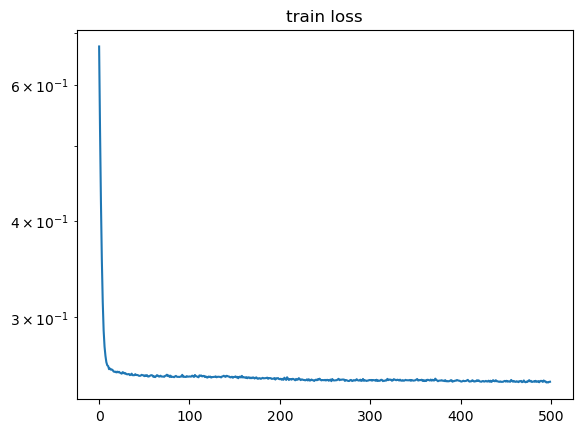

In [170]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f6, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/train_loss_f6.png')
plt.show()

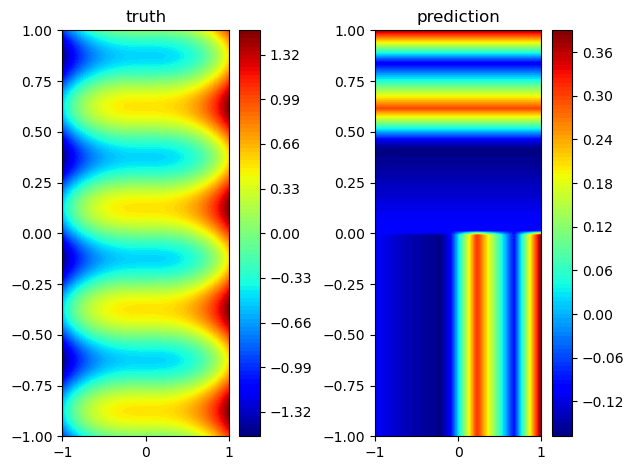

In [171]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/truth_prediction_f6.png')
plt.show()